In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
from IPython.display import clear_output
import tensorflow as tf

filename = '/content/drive/MyDrive/loadwalks.py'
exec(open(filename).read())



num_dims = 2

dim_size = 1000

numWalks = 1000

#Make as general as possible
steps =  2000 #int(1.5*dim_size + (1.5*dim_size)*(num_dims - 1))

size_dims = [dim_size for i in range(num_dims)]



In [ ]:
def shuffle(elements):
  p = [1/num_axis for i in range(num_axis)]
  picks = np.random.choice(elements, num_axis, p=p, replace = False)
  return picks


def NewgenSets():
  probs = []
  prob_groups = [[.30001,.4],[.40001,.5],[.70001,.8],[.90001,.99999]]

  both = {}
  bound = 1

  while sum(probs) < 1:
    print(len(probs))
    if len(probs) == 0:
      temp_index = numWalks % 4
      prob_groups[temp_index]
      bound = np.random.uniform(low = prob_groups[temp_index][0], high = prob_groups[temp_index][1])
      probs.append(bound)
    if len(probs)== num_axis - 1:
      probs.append(1-sum(probs))
      break

    bound = np.random.uniform(low = 0.0, high = 1-sum(probs))
    probs.append(bound)
  movements = shuffle(elements)
  zip_iterator = zip(movements,probs)
  both = dict(zip_iterator)
  return movements,probs,both


def get_Movement(elements,probabilities):
  choice = np.random.choice(elements, 1, p=probabilities)[0]
  return choice

def update(position):
  position = tuple(position)
  space[position] += 1
  position = list(position)


#Note make more general version where user chooses random corner, lowest value corner, max corner, center, or random position


def get_starting_position(setting):
  if setting == "Max": #to start in the corner with maximum proabilities
    max1 = max([both[axis] for axis in sorted(both)[:2]])

    max2 = max([both[axis] for axis in sorted(both)[2:4]])    
    directions = [list(both.keys())[list(both.values()).index(j)] for j in [max1,max2]]
    
    
    dict_counts_finite[directions[0]] += .5
    dict_counts_finite[directions[1]] += .5
    indices = [int(k[-1]) for k in directions]

    if indices[0]//2 != indices[1]//2:
      indices.sort()
      position = []

      for index in indices:
        if index % 2 == 0:
          position.append(0)
        else:
          position.append(dim_size - 1)

      return position
    

  if setting == "Center":  #to start in center
    position = [size_dims[j]//2 for j in range(num_dims)]

    return position
  
  if setting == "Random":
    position = [np.random.randint(low = 0, high = dim_size - 1) for j in range(num_dims)]
    return position

def check_corner():
  walls = []

  if position[0] - 1 <= 0:
    #Found Upper Wall
    walls.append("Axis0")
  if position[0] + 1 >= dim_size - 1:
    #Found Lower Wall
    walls.append("Axis1")
  if position[1] - 1 <= 0:
    #Found Left Wall
    walls.append("Axis2")
  if position[1] + 1 >= dim_size - 1:
    #Found Right Wall
    walls.append("Axis3")

  return walls

def update_corner():
  walls = check_corner()
  
  if len(walls) == 1:
    dict_counts_finite[walls[0]] += 1

  if len(walls) == 2:
    if dict_counts_finite[walls[1]] != 0:
      proportion = dict_counts_finite[walls[0]]/dict_counts_finite[walls[1]]
      points2 = 1/(1+proportion)
    else:
      
      points2 = .5
    points1 = 1-points2

    dict_counts_finite[walls[0]] += points1
    dict_counts_finite[walls[1]] += points2

def writeSingleImageDataset(arr,path,y_true):

  with h5py.File(path, 'w') as f:
    if y_true == 1:
      dset = f.create_dataset("default", (numWalks,4))
      dset[0:len(arr)] = arr

    else:  
      dset = f.create_dataset("default", (numWalks,dim_size,dim_size))
      dset[0:len(arr)] = arr
    f.close()

  return print("completed")



def RMSE(arr1,arr2):

  r = (arr1-arr2)**2

  r = r.sum()/(4*numWalks)  #Scale down the walks to calculate mean square error

  r = r**.5 #Calculate RMSE for entire model

  return r



In [ ]:
num_axis = 2*num_dims
positions = []
walks = []
targets = []
infinite_approxs = []
finite_approxs = []

elements = ["Axis{}".format(i) for i in range(num_axis)]


for i in range(numWalks):
  dict_counts_infinite = {"Axis0":0,"Axis1":0,"Axis2":0,"Axis3":0}
  dict_counts_finite = {"Axis0":0,"Axis1":0,"Axis2":0,"Axis3":0}
  clear_output(wait=True)
  space = np.zeros(size_dims)
  elementsCurrent,probabilities, both= NewgenSets()
  print(probabilities)
  #probabilities = [0.25199604, 0.10922468, 0.30587924, 0.33290005]
  #elementsCurrent = ["Axis0","Axis1","Axis2","Axis3"]
  count_steps_only = 0

  for ii in range(steps): 
    if ii == 0:
      setting = "Center"    #Determine starting position 
      position = get_starting_position(setting)
      print("Starting position:{}".format(position))
      update(position)
    else:
      direction = get_Movement(elementsCurrent,probabilities)
      dict_counts_infinite[direction] += 1
      index = int(direction[-1])
      if index % 2 == 0:
        if position[index//2] - 1 > 0: 
          position[index//2] -= 1
          update(position)
          dict_counts_finite[direction] += 1

        else:
          update_corner()
          update(position)

      else:
        if position[index//2] + 1 < size_dims[index//2]:    
          position[index//2] += 1
          update(position)
          dict_counts_finite[direction] += 1
        else:
          update_corner()
          update(position)

      
  target = [both[_] for _ in elements]

  brute_infinite_approx = [dict_counts_infinite[_]/(steps - 1) for _ in elements]
  brute_finite_approx = [dict_counts_finite[_]/(steps - 1) for _ in elements]

  
  print("Current Progress:",np.round((i/numWalks)*100,2), "%")
  infinite_approxs.append(brute_infinite_approx)
  finite_approxs.append(brute_finite_approx)
  targets.append(target)
  #space = space/steps scale by steps if needed

  walks.append(space)


print(targets[0])
plt.imshow(walks[0])

print("Infinite Predictor: ",dict_counts_infinite)
print("Finite Predictor: ", dict_counts_finite)



0
2
3
[0.4920336507616002, 0.17080430601320018, 0.07633492715268543, 0.2608271160725142]
Starting position:[2000, 2000]


array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:

#Make binary
walks = np.array(walks)
walks = np.reshape(walks, (numWalks,dim_size*dim_size))
for j in range(len(walks)):
  for i in range(len(walks[j])):
    if walks[j][i] !=0:
      walks[j][i] = 1




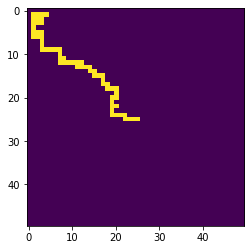

In [ ]:
walks = np.array(walks)
walks = np.reshape(walks, (numWalks,dim_size,dim_size))
plt.imshow(walks[0])

In [ ]:

walks = np.array(walks)
walks = np.reshape(walks, (numWalks,dim_size,dim_size))

targets = np.array(targets)
targets = np.reshape(targets, (numWalks,4))

infinite_approxs = np.array(infinite_approxs)
infinite_approxs = np.reshape(infinite_approxs, (numWalks,4))

finite_approxs = np.array(finite_approxs)
finite_approxs = np.reshape(finite_approxs, (numWalks,4))


In [ ]:
filename = '/content/drive/MyDrive/confidenceintervals.py'
exec(open(filename).read())


'our mean lies in the interval ]1.0, 1.0['

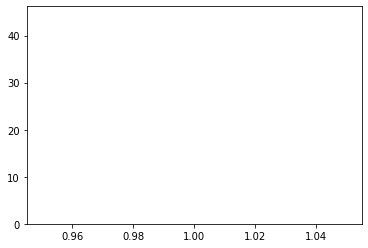

In [ ]:

sums = [sum(array) for array in finite_approxs]
plt.hist(sums)
sum(sums)/len(sums)
report_confidence_interval(confidence_interval(sums, confidence=0.95))

In [ ]:
s = walks.sum(axis=0)


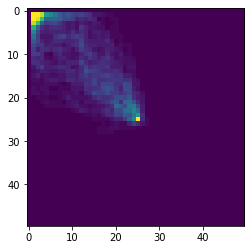

In [ ]:
#s = s/(numWalks*steps)
plt.imshow(s)

[0.17556211 0.33601639 0.12639447 0.36202702]


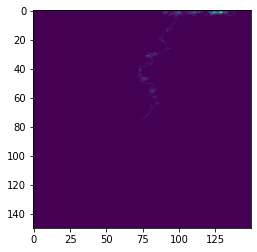

In [ ]:
N = 22


plt.imshow(walks[N])
print(targets[N])

In [ ]:
n = 22

print(finite_approxs[n])
print(infinite_approxs[n])
print(targets[n])

[0.24579664 0.1008807  0.30424339 0.34907926]
[0.24579664 0.1008807  0.30424339 0.34907926]
[0.17556211 0.33601639 0.12639447 0.36202702]


In [ ]:
print("RMSE of finite_approxs and targets is: {}".format(RMSE(finite_approxs,targets)))  
print("RMSE of infinite_approxs and targets is: {}".format(RMSE(infinite_approxs,targets)))                                     
print("RMSE of infinite_approxs and finite_approxs is: {}".format(RMSE(finite_approxs,infinite_approxs)))                                     

RMSE of finite_approxs and targets is: 0.18493353674414068
RMSE of infinite_approxs and targets is: 0.1848955626198883
RMSE of infinite_approxs and finite_approxs is: 0.0009057100043517459


In [ ]:
path1 = ''   #Put custom path
path2 = '' #Put custom path


writeSingleImageDataset(walks,path1,0)
writeSingleImageDataset(targets,path2,1)

completed
completed
